# Nonlinear Examples

We will examine some nonlinear examples on which the SOS decomposition method is applied.

In [19]:
# Set up the workspace
using SumOfSquares, JuMP, PolyJuMP, DynamicPolynomials, MultivariatePolynomials
using Mosek#, CSDP#, SCS
using Plots
gr()

include("../src/NormalSoS.jl")
using NormalSoS

include("../src/MinimumActionPath.jl")
using MAP

include("../src/GeomMinActPath.jl")
using gMAM

## Maier-Stein model

The widely studied Maier-Stein model may offer either a pure gradient system or one for which an orthogonal decomposition does not exist.

In [20]:
# The Maier-Stein model
γ = 10.0;    μ = 1.0;
@polyvar x[1:2]
F(X::Vector) = [X[1] - X[1]^3 - γ*X[1]X[2]^2;
                 -μ*(X[1]^2 + 1)X[2]];
f = F(x);
V = -0.5*x[1]^2 + 0.25*x[1]^4 + 0.5γ*x[2]^2 + 0.5γ*x[1]^2*x[2]^2;
@time U = NormalSoS.normdecomp(f,x)

fg = -differentiate(U,x)
Fg(X::Vector) = [Float64(subs(fg[1],x[1]=>X[1], x[2]=>X[2]));
                 Float64(subs(fg[2],x[1]=>X[1], x[2]=>X[2]))];
fc = f + differentiate(U,x)
Fc(X::Vector) = [Float64(subs(fc[1],x[1]=>X[1], x[2]=>X[2]));
                 Float64(subs(fc[2],x[1]=>X[1], x[2]=>X[2]))];


Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^4, x1^3x2, x1^2x2^2, x1^3, x1^2x2, x1x2^2, x1^2, x1x2, x2^2, x1, x2, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 544             
  Cones                  : 0               
  Scalar variables       : 15              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  

MOSEK warning 705: #3 (nearly) zero elements are specified in sparse row ''(544) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(545) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(546) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(548) of matrix 'A'.
MOSEK warning 705: #6 (nearly) zero elements are specified in sparse row ''(549) of matrix 'A'.
MOSEK warning 705: #5 (nearly) zero elements are specified in sparse row ''(550) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(551) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(552) of matrix 'A'.
MOSEK warning 705: #4 (nearly) zero elements are specified in sparse row ''(553) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type  

  1.843687 seconds (754.62 k allocations: 38.725 MiB, 1.13% gc time)


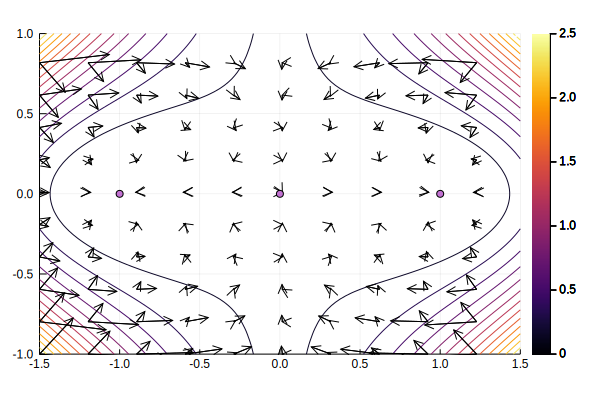

In [18]:
NormalSoS.plotlandscape(f, U, x, ([-1.5 1.5], [-1.0 1.0]), true)
plot!([-1 0 1]',[0 0 0]', line=0, marker=4, legend=false)

In [58]:
# Obtain the minimum action path
x₀ = [-1.0 0.0];  # Start point (row vector)
Tspan = 10.0;  # Time span
N = 400;
σ = 1.0;
G(X::Vector) = σ*[1.0; 1.0];

dt = 0.02;    M=500;

xₑ = [-0.4 0.0];
φ₀ = MAP.makepath(x₀,xₑ,N);
for ii=1:N-2
    φ₀[ii,2] = 0.1*randn();
end
resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀);
φ₁ = [x₀; Optim.minimizer(resObj); xₑ];
ψ₁ = zeros(Float64,M,2);
ψ₁[1,:] = xₑ;
for ii=2:M
    ψ₁[ii,:] = ψ₁[ii-1,:] + (-Fc(ψ₁[ii-1,:])+Fg(ψ₁[ii-1,:]))dt;
end

xₑ = [-1.0 0.6];
φ₀ = MAP.makepath(x₀,xₑ,N);
resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀);
φ₂ = [x₀; Optim.minimizer(resObj); xₑ];
ψ₂ = zeros(Float64,M,2);
ψ₂[1,:] = xₑ;
for ii=2:M
    ψ₂[ii,:] = ψ₂[ii-1,:] + (-Fc(ψ₂[ii-1,:])+Fg(ψ₂[ii-1,:]))dt;
end

Sm = gMAM.action(φ₁,F,G);
Ss = gMAM.action(flipdim(ψ₁,1),F,G);
Su = Float64(subs(U,x[1]=>xₑ[1],x[2]=>xₑ[2])) - Float64(subs(U,x[1]=>x₀[1],x[2]=>x₀[2]));
@show(Sm);    @show(Ss);    @show(Su);


Optimisation for T=10.00 gives S=0.35
Optimisation is not converged, rerunning...
Optimisation for T=10.00 gives S=0.35
Optimisation is converged.
Optimisation for T=10.00 gives S=0.72
Optimisation is converged.
Sm = 0.17638858053076995
Ss = 0.17639264231797822
Su = 0.35999993559562427


In [59]:
mapPlt = plot([ψ₁[:,1];flipdim(ψ₂,1)[:,1]],[ψ₁[:,2];flipdim(ψ₂,1)[:,2]], line=2, marker=0,label="SoS");
plot!(mapPlt, [φ₁[:,1];φ₂[:,1]],[φ₁[:,2];φ₂[:,2]], line=0, marker=3, label="MAP")
plot!(mapPlt, xlims=(-1.35,-0.35),ylims=(-0.05,0.65), size=(400,350))

### Quasipotential comparison

We now plot a comparison bewteen the true and SOS computed quasipotential along a line.

In [6]:
γ = 1.0;    μ = 1.0;
@polyvar x[1:2]
F(X::Vector) = [X[1] - X[1]^3 - γ*X[1]X[2]^2;
                 -μ*(X[1]^2 + 1)X[2]];
f = F(x);
U = NormalSoS.normdecomp(f,x, MosekSolver(),2);
fg = -differentiate(U,x)
Fg(X::Vector) = [Float64(subs(fg[1],x[1]=>X[1], x[2]=>X[2]));
                 Float64(subs(fg[2],x[1]=>X[1], x[2]=>X[2]))];
fc = f + differentiate(U,x)
Fc(X::Vector) = [Float64(subs(fc[1],x[1]=>X[1], x[2]=>X[2]));
                 Float64(subs(fc[2],x[1]=>X[1], x[2]=>X[2]))];

σ = 1.0;
G(X::Vector) = σ*[1.0; 1.0];

Tspan = 10.0;  # Time span
N = 400;
x₀ = [-1.0 0.0];
dt = 0.02;    M=500;

xVec = collect(-1.5:0.1:0.0)
Smx = zeros(xVec);
Ssx = zeros(xVec);
for (idx,xi) in enumerate(xVec)
    xₑ = [xi 0];
    φ₀ = MAP.makepath(x₀,xₑ,N);
    for ii=1:N-2
        φ₀[ii,2] = 0.1*randn();
    end
    
    # Find the optimal path and true action
    resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀);
    φ = [x₀; Optim.minimizer(resObj); xₑ];
    Smx[idx] = gMAM.action(φ,F,G);
    
    # Compute the SOS predicted action
    ψ = zeros(Float64,M,2);
    ψ[1,:] = xₑ;
    for ii=2:M
        ψ[ii,:] = ψ[ii-1,:] + (-Fc(ψ[ii-1,:])+Fg(ψ[ii-1,:]))dt;
    end
    Ssx[idx] = gMAM.action(flipdim(ψ,1),F,G);
end

xVec = collect(-1.5:0.1:1.5)
Smy = zeros(xVec);
Ssy = zeros(xVec);
for (idx,xi) in enumerate(xVec)
    xₑ = [-1.0 xi];
    φ₀ = MAP.makepath(x₀,xₑ,N);
    for ii=1:N-2
        φ₀[ii,2] = 0.1*randn();
    end
    
    # Find the optimal path and true action
    resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀);
    φ = [x₀; Optim.minimizer(resObj); xₑ];
    Smy[idx] = gMAM.action(φ,F,G);
    
    # Compute the SOS predicted action
    ψ = zeros(Float64,M,2);
    ψ[1,:] = xₑ;
    for ii=2:M
        ψ[ii,:] = ψ[ii-1,:] + (-Fc(ψ[ii-1,:])+Fg(ψ[ii-1,:]))dt;
    end
    Ssy[idx] = gMAM.action(flipdim(ψ,1),F,G);
end

Chosen basis as:
DynamicPolynomials.Monomial{true}[x1^4, x1^3x2, x1^2x2^2, x1^3, x1^2x2, x1x2^2, x1^2, x1x2, x2^2, x1, x2, 1]
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 544             
  Cones                  : 0               
  Scalar variables       : 15              
  Matrix variables       : 2               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  

1   1.9e-01  3.8e+02  8.3e-02  -9.99e-01  -1.237738148e+03  -2.026043011e+02  1.9e-01  0.05  
2   2.8e-02  5.7e+01  5.0e-03  -9.93e-01  -1.005632206e+04  -2.258643062e+03  2.8e-02  0.08  
3   2.5e-03  5.1e+00  1.5e-04  -9.43e-01  -8.816611482e+04  -2.246798207e+04  2.5e-03  0.11  
4   4.1e-04  8.5e-01  2.8e-05  -4.23e-01  -9.907768287e+04  -4.325900064e+04  4.1e-04  0.13  
5   1.0e-04  2.1e-01  4.1e-05  1.38e+00   -1.569209662e+04  -1.414587341e+04  1.0e-04  0.16  
6   1.6e-05  3.4e-02  4.1e-05  2.09e+00   -1.399309056e+03  -1.358488131e+03  1.6e-05  0.19  
7   1.3e-06  2.6e-03  9.7e-06  1.07e+00   -1.068911353e+02  -1.024057357e+02  1.3e-06  0.22  
8   1.2e-07  2.4e-04  1.7e-06  8.11e-01   -1.060016026e+01  -9.370067260e+00  1.2e-07  0.24  
9   4.3e-09  8.7e-06  3.0e-07  9.96e-01   -3.932415351e-01  -3.432860779e-01  4.2e-09  0.27  
10  1.0e-10  3.1e-08  1.9e-08  1.01e+00   -1.393481715e-03  -1.229470966e-03  1.5e-11  0.29  
11  7.7e-11  1.5e-08  1.3e-08  9.99e-01   -6.997287948e-04  

  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 568             
  Cones                  : 0               
  Scalar variables       : 14              
  Matrix variables       : 3               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 566
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 15                conic                  : 13              
Optimizer  - Semi-definite variables: 3                 scalarized             : 1771            
Factor     - setup time             : 0.02              dense det. time        : 0.00            
Factor     - ML order time          : 0.01              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.42e+0

Optimisation for T=10.00 gives S=0.78
Optimisation is converged.
Optimisation for T=10.00 gives S=0.46
Optimisation is converged.
Optimisation for T=10.00 gives S=0.24
Optimisation is not converged, rerunning...
Optimisation for T=10.00 gives S=0.24
Optimisation is converged.
Optimisation for T=10.00 gives S=0.10
Optimisation is converged.
Optimisation for T=10.00 gives S=0.02
Optimisation is converged.
Optimisation for T=10.00 gives S=0.00
Optimisation is converged.
Optimisation for T=10.00 gives S=0.02
Optimisation is converged.
Optimisation for T=10.00 gives S=0.06
Optimisation is converged.
Optimisation for T=10.00 gives S=0.13
Optimisation is converged.
Optimisation for T=10.00 gives S=0.20
Optimisation is converged.
Optimisation for T=10.00 gives S=0.28
Optimisation is not converged, rerunning...
Optimisation for T=10.00 gives S=0.28
Optimisation is converged.
Optimisation for T=10.00 gives S=0.35
Optimisation is converged.
Optimisation for T=10.00 gives S=0.41
Optimisation is co

In [8]:
plt = plot(plot(ylim=(0.0,0.4)), plot(ylim=(0.0,4.0), legend=false), layout = @layout([a; b]), size=(400,700))

xVec = collect(-1.5:0.1:0.0)
Us = xi->Float64(subs(U,x[1]=>xi,x[2]=>x₀[2])) - Float64(subs(U,x[1]=>x₀[1],x[2]=>x₀[2]));
plot!(plt[1], collect(xVec[1]:0.01:xVec[end]),Us, label="U")
plot!(plt[1], xVec,Smx, line=0, marker=3, label="MAP")
plot!(plt[1], xVec,Ssx, line=0, marker=(3,:x), label="SOS")

xVec = collect(-1.5:0.1:1.5)
Us = xi->Float64(subs(U,x[1]=>x₀[1],x[2]=>xi)) - Float64(subs(U,x[1]=>x₀[1],x[2]=>x₀[2]));
plot!(plt[2], collect(xVec[1]:0.01:xVec[end]),Us, label="U")
plot!(plt[2], xVec,Smy, line=0, marker=(3), label="MAP")
plot!(plt[2], xVec,Ssy, line=0, marker=(3,:x), label="SOS")